# Model based analysis Risk & Ambiguity
#### Korem et al., 2023?

This notebook loads the R&A task from the aging project and uses variations of the utility function to try and model the effects of aging on forced choice lottery selection in the medical domain. 

#### Step 1 model behavior

Choices in the medical domain are quantitatively different. </br>
Using computational model we will try to see if we can estimate the value. </br>
We will test 3 models: </br>
    1. No individual parameters </br>
    2. Only ambiguity aversion </br>
    3. Both ambiguity and probability weighting 
   
#### Step 2 model age

Take the best model and check if we add age parameters

#### Step 3 validate the model using monetary data and compare it to more classical approaches

compare the qualitative model to:</br>
    1. No individual parameters</br>
    2. Classical utility function</br>
    3. "Trembling hand" model


## Step 0

### Load libraries 


In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# PyMC for Bayesian statistical modeling and probabilistic machine learning
import pymc as pm
# ArviZ for exploratory analysis of Bayesian models
import arviz as az

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# load demographic data
age = pd.read_csv('../demo.csv')

# load choice data
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  98 participants medical:  98


## Preprocessing 

In [3]:
# Extract unique subject numbers from the 'age' and 'db_mon' dataframes.
s_am = list(age['sub'].unique())  # Subjects from the 'age' dataframe
s_ra = list(db_mon['sub'].unique())  # Subjects from the 'db_mon' dataframe

# Identify subjects who are present in one list but not in the other.
demo_no_ra = list(set(s_am) - set(s_ra))  # Participants in 'age' but not in 'db_mon'
ra_no_demo = list(set(s_ra) - set(s_am))  # Participants in 'db_mon' but not in 'age'

# Print the participants who are in the 'db_mon' dataset but do not have MoCA data.
print('pariticpant with R&A and no MoCA:', ra_no_demo)


# Filter the 'age' dataframe to only include participants who are also present in the 'db_mon' dataframe.
age = age[age['sub'].isin(db_mon['sub'].values)]

# Merge the demographic data (age, MoCA score, and gender) with the 'db_mon' and 'db_med' datasets.
# This provides a consolidated view where each participant's data from different sources is combined into one row.
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')  # Merge with 'db_mon'
db_med = db_med.merge(age, left_on='sub', right_on='sub')  # Merge with 'db_med'

# Filter participants based on their MoCA score. 
# Only include cognitive healthy participants (MoCA score greater than 25).
db_mon = db_mon[db_mon['moca_score'] > 25]
db_med = db_med[db_med['moca_score'] > 25]

# Print the total number of participants who have all required data (after merging and filtering).
print('Number of participants with all data:', len(db_med['sub'].unique()))

pariticpant with R&A and no MoCA: [12, 21, 22, 31, 34, 35, 45, 47, 48, 53, 54, 62, 64, 65, 67, 70, 79, 81, 84, 89, 91, 97, 98, 99, 110, 112, 114]
Number of participants with all data: 71


#### Remove subjects who are too risk averse

In [4]:
# Define a threshold for the minimum number of trials in which a participant chose the lottery option.
risk_min = 2

# For each participant in the 'db_mon' and 'db_med' datasets, sum up the number of times they chose the lottery option.
choices_mon = db_mon[['sub', 'choice']].groupby(['sub']).sum()  # For 'db_mon' dataset
choices_med = db_med[['sub', 'choice']].groupby(['sub']).sum()  # For 'db_med' dataset

# Identify participants who chose the lottery less than the threshold (risk_min) and are thus considered too risk-averse.
too_risk_averse_mon = list(choices_mon[choices_mon['choice'] < risk_min].index)  # For 'db_mon' dataset
too_risk_averse_med = list(choices_med[choices_med['choice'] < risk_min].index)  # For 'db_med' dataset

# Print the participants who are too risk-averse for both monetary and medical scenarios.
print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)

# Exclude the too risk-averse participants from the 'db_mon' and 'db_med' datasets.
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# Extract unique participants from the updated 'db_mon' and 'db_med' datasets.
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

# Filter both datasets to only include participants that are present in both.
# This ensures consistency and allows for direct comparisons between the monetary and medical scenarios.
db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

# Print the number of participants retained after the above filters.
print('Subjects who were not too risk averse: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Monetary too risk averse ( 2 ):  [11, 40]
Medical too risk averse ( 2 ):  []
Subjects who were not too risk averse:  69 69


#### Remove participants who failed too many catch trials

In [5]:
# Identify participants in the 'db_mon' and 'db_med' datasets who failed 7 or more catch trials out of 12.
mon_catch = db_mon[db_mon.catch >= 7]  # For 'db_mon' dataset
med_catch = db_med[db_med.catch >= 7]  # For 'db_med' dataset

# Extract the unique participant identifiers for those who failed catch trials in both datasets.
mon_catch_n = mon_catch['sub'].unique()  # For 'db_mon' dataset
med_catch_n = med_catch['sub'].unique()  # For 'db_med' dataset

# Print the participants who failed catch trials in both monetary and medical scenarios.
print('Subjects who failed catch trials: mon:', mon_catch_n, '; med:', med_catch_n)

# Exclude participants from both datasets who failed 7 or more catch trials out of 12.
db_med = db_med[db_med.catch < 7]
db_mon = db_mon[db_mon.catch < 7]

# Extract unique participants from the updated 'db_mon' and 'db_med' datasets.
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

# Filter both datasets to only include participants that are present in both.
# This step ensures that participants who failed the catch trials in one scenario but not in the other are excluded from both.
db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

# Print the number of participants retained after excluding those who failed the catch trials.
print('Subjects who didn not fail attention check: ', len(db_mon['sub'].unique()), len(db_med['sub'].unique()))

Subjects who failed catch trials: mon: [ 17  27 111] ; med: [111]
Subjects who didn not fail attention check:  66 66


Remove trials with no response

In [6]:
# For the 'db_med' dataset:

# Remove rows with missing data.
db_med = db_med.dropna()

# Convert the 'choice' column to integer data type.
db_med['choice'] = db_med['choice'].astype('int')

# Sort the dataset based on the 'sub' (subject) column for easier comparison in later analyses.
db_med = db_med.sort_values('sub').reset_index(drop=True)

# Assign a unique serial number for each participant. This will be useful for indexing operations.
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_med' dataset.
n_subs_med = db_med['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_med' dataset.
sub_idx_med = db_med.subn.tolist()

# Print the final number of subjects and trials in the 'db_med' dataset.
print("Final sample Medical includes {} subjects and {} valid trials".format(n_subs_med, len(sub_idx_med)))


# For the 'db_mon' dataset (similar processing as for 'db_med'):

# Remove rows with missing data.
db_mon = db_mon.dropna()

# Convert the 'choice' column to integer data type.
db_mon['choice'] = db_mon['choice'].astype('int')

# Sort the dataset based on the 'sub' (subject) column for easier comparison in later analyses.
db_mon = db_mon.sort_values('sub').reset_index(drop=True)

# Assign a unique serial number for each participant.
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = db_mon['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = db_mon.subn.tolist()

# Print the final number of subjects and trials in the 'db_mon' dataset.
print("Final sample Monetary includes {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample Medical includes 66 subjects and 5501 valid trials
Final sample Monetary includes 66 subjects and 5518 valid trials


### Add categories

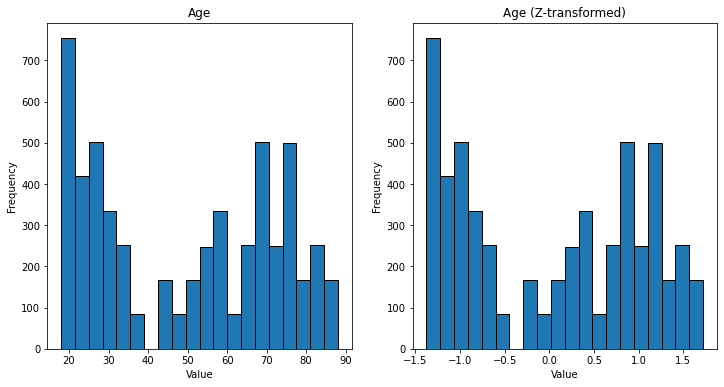

In [7]:
# For the 'db_med' dataset:

# Create a new column 'level' in the 'db_med' dataset by ranking the 'value' column using the dense method.
db_med['level'] = db_med['value'].rank(method='dense').astype(int)

# Create dummy variables (indicators) for each level by comparing 'level' to thresholds from 0 to 3.
db_med['l1'] = db_med.level > 0
db_med['l2'] = db_med.level > 1
db_med['l3'] = db_med.level > 2
db_med['l4'] = db_med.level > 3

# Convert the boolean dummy variables to integers (0 or 1).
db_med['l1'] = db_med['l1'].astype(int)
db_med['l2'] = db_med['l2'].astype(int)
db_med['l3'] = db_med['l3'].astype(int)
db_med['l4'] = db_med['l4'].astype(int)

# For the 'db_mon' dataset:

# Rank the 'value' column in the 'db_mon' dataset.
db_mon['level'] = db_mon['value'].rank(method='dense').astype(int)

# Create dummy variables for each level in the 'db_mon' dataset.
db_mon['l1'] = db_mon.level > 0
db_mon['l2'] = db_mon.level > 1
db_mon['l3'] = db_mon.level > 2
db_mon['l4'] = db_mon.level > 3

# Convert boolean indicators to integers.
db_mon['l1'] = db_mon['l1'].astype(int)
db_mon['l2'] = db_mon['l2'].astype(int)
db_mon['l3'] = db_mon['l3'].astype(int)
db_mon['l4'] = db_mon['l4'].astype(int)

# Z-transform the 'age' variable for both datasets to have a mean of 0 and a standard deviation of 1. 
db_mon['ageZ'] = (db_mon['age'] - db_mon['age'].mean()) / db_mon['age'].std()
db_med['ageZ'] = (db_med['age'] - db_med['age'].mean()) / db_med['age'].std()

# Create a subplot layout with 1 row and 2 columns.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original 'age' histogram for the 'db_mon' dataset on the first subplot.
axes[0].hist(db_mon['age'], bins=20, edgecolor='black')
axes[0].set_title('Age')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the Z-transformed 'ageZ' histogram for the 'db_mon' dataset on the second subplot.
axes[1].hist(db_mon['ageZ'], bins=20, edgecolor='black')
axes[1].set_title('Age (Z-transformed)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Display the created plots.
plt.show()


### Final sample descriptives

Total: 66 
Females:  30


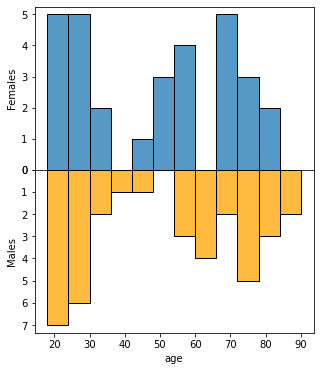

In [8]:
# Drop duplicates based on the 'sub' (subject) column to get unique participants
participants = db_mon.drop_duplicates(['sub'])

# Create a subplot layout with 2 rows and 1 column.
fig, ax = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

# On the first subplot (top), plot the age distribution for female participants
sns.histplot(participants[participants['gender'] == 'F']['age'], binwidth=6, ax=ax[0])

# On the second subplot (bottom), plot the age distribution for male participants using an orange color
sns.histplot(participants[participants['gender'] == 'M']['age'], binwidth=6, color='orange', ax=ax[1])

# Set the y-labels for both subplots to denote the gender, and only set an x-label for the bottom plot
ax[0].set(ylabel='Females', xlabel='')
ax[1].set(ylabel='Males')

# Invert the y-axis for the male age distribution to have the histogram bars grow upwards 
# (this makes it visually comparable with the female age distribution)
ax[1].invert_yaxis()

# Adjust the space between subplots to make them touch (removing any gap)
plt.subplots_adjust(wspace=0, hspace=0)

# Print out the total number of unique participants and the number of female participants
print("Total:", participants.shape[0], "\nFemales: ", participants[participants['gender'] == 'F'].shape[0])

## Step 1 Modeling medical decisions

### Model 1: no individual parameters

In [9]:
def straw_man(df, n_subs, idx):
    """
    A simple model (straw man) that tries to estimate the influence of value, risk, and ambiguity 
    on the choice made by subjects in a gambling scenario.

    Parameters:
    - df: DataFrame containing data on choice, value, risk, and ambiguity for each trial
    - n_subs: Number of subjects in the study
    - idx: Subject index for each trial (used for hierarchical modeling)

    Returns:
    - trace: Samples from the posterior distribution
    """
    
    with pm.Model() as simple:  # Define a new PyMC3 model
    
        # Define hyperpriors for the group-level parameter (γ)
        gMu = pm.Normal('gMu',  0, 1) # Mean of the normal distribution
        gSig = pm.Gamma('gSig', 2, 1) # Standard deviation (Gamma distribution provides only positive values)

        # Define the subject-specific risk preference (γ) using a lognormal distribution
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # Compute expected value of the lottery outcome
        val  = df['value'].values                                # Values from the 'value' column in the DataFrame
        prob = df['risk'].values - (df['ambiguity'].values / 2)  # Probability calculation adjusted by ambiguity

        svLotto = val * prob # Subjective value of the lottery
        svRef   = 1          # Subjective value of a reference (assumed to be 1)

        # Define the linear predictor (p) and compute the expected probability (mu) using the inverse logit function
        p  = (svLotto - svRef) / γ[idx]
        mu =  pm.invlogit(p)                     # The invlogit function transforms values to the (0,1) interval

        # Define the likelihood of the observed data. A binomial likelihood is chosen because the outcome is binary (choice is 0 or 1)
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample()
        
    return(trace)

### Model 2: Unique values

In [10]:
def estimate_values_no_hyper(df, n_sub, idx):
    """
    Estimate the value of the different levels without a common hyperprior.

    Parameters:
    - df: DataFrame containing trial-specific information like choices, value levels, risks, and ambiguity.
    - n_sub: Number of individual subjects in the dataset.
    - idx: A list or array representing the subject ID for each observation/trial.

    Returns:
    - trace: Posterior samples for the model's parameters.
    """
    
    with pm.Model() as estimate:  # Begin defining a probabilistic model with PyMC3

        # Define hyperparameters for the group-level distributions
        gMu  = pm.Normal('gMu', 0, 1)    # Mean for the inverse temp
        gSig = pm.Gamma('gSig', 2, 1)    # Standard deviation for the inverse temp distribution
        bMu  = pm.Normal('bMu', .65, 1)  # Mean for the ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)    # Standard deviation for the ambiguity effect distribution

        # Define subject-specific priors
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_sub)  # Ambiguity modulation effect
        γ = pm.Lognormal('γ',       gMu, gSig,                            shape = n_sub)                                   
        
        # Priors for individual-level subjective value categories. Each subject has a unique valuation for each level.
        level1 = pm.Normal('level1', 1, 1, shape = n_sub)  # Value for level 1
        level2 = pm.Normal('level2', 1, 1, shape = n_sub)  # Value for level 2
        level3 = pm.Normal('level3', 1, 1, shape = n_sub)  # Value for level 3
        level4 = pm.Normal('level4', 1, 1, shape = n_sub)  # Value for level 4

        # Calculate the total expected value for each trial by summing up values from all levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate the modified probability taking into account both risk and the effect of ambiguity modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))

        # Calculate the subjective value (SV) of the lottery option for each trial
        svLotto = val * prob
        svRef   = level1[idx] 

        # Transform SV into a probability of selecting the lottery option using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Define the likelihood of the observed choices given the expected probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        # Sample from the posterior distribution to obtain parameter estimates
        trace = pm.sample(tune=2000, target_accept=0.95)
        
    return(trace)

In [11]:
def estamte_values(df, n_subs, idx):
    """
    Estimate the value of the different levels with common hyper prior for each level.

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_sub: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    with pm.Model() as estimated:
    
        # Hyperparameters for group-level distributions
        gMu  = pm.Gamma('gMu', 3, 1)
        gSig = pm.Gamma('gSig', 3, 1)

        bMu  = pm.Normal('bMu', .65, 1)
        bSig = pm.Gamma('bSig', 2,   1)
        
        # Hyperparameters for level estimates
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=.1)
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=.1)
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=.1)
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=.1)

        l1sd = pm.Gamma('l1sd', 3, 1)
        l2sd = pm.Gamma('l2sd', 3, 1)
        l3sd = pm.Gamma('l3sd', 3, 1)
        l4sd = pm.Gamma('l4sd', 3, 1)
        
        # Priors for the different levels of subjective values. This structure avoids increase in the mean or the SD.
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # to avoid the increasing the mean or the SD we sampled each category seperatly and sumed them up
        level1 = pm.Normal('level1', l1Mu, l1sd, shape = n_subs)
        level2 = pm.Normal('level2', l2Mu, l2sd, shape = n_subs)
        level3 = pm.Normal('level3', l3Mu, l3sd, shape = n_subs)
        level4 = pm.Normal('level4', l4Mu, l4sd, shape = n_subs)

        # Compute the total expected value for each trial using different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]
              )   

        # Risk and ambiguity calculation: Risk is modulated by ambiguity and its effect can be different for each subject (β[idx])
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value (SV) of the lottery for each trial
        svLotto = val * prob
        svRef   = level1[idx] 

        # Convert SV into a probability of choosing the lottery using the inverse logit function
        p  = (svLotto - svRef)/γ[idx]
        mu = pm.invlogit(p)

        # Define the likelihood using the observed choices. Binomial since choice is binary.
        choice = pm.Binomial('choice',1, mu, observed=df['choice'])

        trace = pm.sample(tune=2000, target_accept=0.95)
        
    return(trace)

In [12]:
def estamte_values_ordinal(df, n_subs, idx):
    """
    Estimate the value of different reward levels using ordinal constraints and a common hyperprior for each level. 
    The model ensures that the levels are positive (ordinal constraints).

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        gMu  = pm.Gamma('gMu', 4, 1)        # Mean for the inverse temperature distribution
        gSig = pm.Gamma('gSig', 3, 1)       # SD for the inverse temperature distribution
        bMu  = pm.Normal('bMu', .65, 1)     # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)       # SD for ambiguity effect distribution

        # Hyperparameters for group-level subjective value levels
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=.1)  # Mean for value of level 1
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=.1)  # ... level 2
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=.1)  # ... level 3
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=.1)  # ... level 4
        l1sd = pm.Gamma('l1sd', 3, 1)  # SD for value of level 1
        l2sd = pm.Gamma('l2sd', 3, 1)  # ... level 2
        l3sd = pm.Gamma('l3sd', 3, 1)  # ... level 3
        l4sd = pm.Gamma('l4sd', 3, 1)  # ... level 4
        
        # Subject-specific priors 
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)   # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)   # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef   = level1[idx]  # The subjective value of the reference option

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(tune=2000, target_accept=0.95)
        
    return trace

In [13]:
def estamte_values_hyper(df, n_subs, idx):
    """
    Estimate the value of different reward levels using hierarchical modeling.
    This version includes additional hyperpriors for the subjective value levels.

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        gMu  = pm.Gamma('gMu', 4, 1)         # Mean for the inverse temperature distribution
        gSig = pm.Gamma('gSig', 3, 1)        # SD for the inverse temperature distribution
        bMu  = pm.Normal('bMu', .65, 1)      # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)        # SD for ambiguity effect distribution

        # Hyper-hyperparameters for the subjective value levels
        Lh = pm.Gamma('lh', 2, 1)            # Mean for the hyperprior of value levels
        LSig = pm.Gamma('LSig', 4, 1)        # SD for the hyperprior of value levels
        
        # Hyperparameters for SD of value levels
        LsdMu = pm.TruncatedNormal('LsdMu', 2, 1, lower=0)  # Mean for the SD of value levels
        LsdSig = pm.Gamma('L1sdSig', 3, 1)                  # SD for the SD of value levels
        
        # Hyperparameters for the individual levels 
        l1Mu = pm.Normal('l1Mu', Lh, LSig)   
        l2Mu = pm.Normal('l2Mu', Lh, LSig)
        l3Mu = pm.Normal('l3Mu', Lh, LSig)
        l4Mu = pm.Normal('l4Mu', Lh, LSig)

        l1sd = pm.Gamma('l1sd', LsdMu, LsdSig)
        l2sd = pm.Gamma('l2sd', LsdMu, LsdSig)
        l3sd = pm.Gamma('l3sd', LsdMu, LsdSig)
        l4sd = pm.Gamma('l4sd', LsdMu, LsdSig)

        # Subject-specific priors
        β = pm.Normal('β', bMu, bSig, shape=n_subs)         # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', gMu, gSig, shape=n_subs)      # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower=0, shape=n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower=0, shape=n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower=0, shape=n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower=0, shape=n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef = level1[idx]  

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(tune=2000, target_accept=0.95)
        
    return trace


## Applying various models to the medical decision dataset to estimate parameters

In [14]:
# A simple model, for a baseline or comparison
med_simple = straw_man(db_med, n_subs_med, sub_idx_med)

# A model estimating values without a shared hyperprior across subjects
med_estimated_no_hyp = estimate_values_no_hyper(db_med, n_subs_med, sub_idx_med)

# A model with shared hyperprior across subjects
med_estimated = estamte_values(db_med, n_subs_med, sub_idx_med)

# A model that applies ordinal constraints to the estimation of subjective values
med_estimated_ord = estamte_values_ordinal(db_med, n_subs_med, sub_idx_med)

# Hierarchical model that includes additional hyperpriors for subjective value levels
med_estimated_hyper = estamte_values_hyper(db_med, n_subs_med, sub_idx_med)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 592 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 515 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 811 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, lh, LSig, LsdMu, L1sdSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 872 seconds.


### Compare models

In [15]:
compare_dict = {
    "No subjective attitudes": med_simple,            
    "No Hyper":                med_estimated_no_hyp,  
    "Estimated Values":        med_estimated,         
    "Ordinal":                 med_estimated_ord,     
    "Hyper estimates":         med_estimated_hyper    
}

# Comparing the different models using ArviZ's compare function. 
# This function  evaluates models based on LOO to determine relative quality.
comp = az.compare(compare_dict)

# Display the comparison result
comp

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Hyper estimates,0,-1405.392787,223.793927,0.000000,8.265660e-01,45.221699,0.000000,True,log
Ordinal,1,-1407.625629,219.302050,2.232842,7.833231e-13,44.506871,1.561836,True,log
Estimated Values,2,-1407.903496,231.433863,2.510710,7.101080e-13,44.065377,3.968307,True,log
No Hyper,3,-1412.601443,250.541810,7.208656,1.591400e-01,44.990583,5.222615,True,log
No subjective attitudes,4,-2929.701966,46.556464,1524.309179,1.429405e-02,32.163131,42.698920,True,log


All estimate model preform similarly. The hyper model shows the best fit.

### Save models

In [16]:
med_simple.to_netcdf("data/med_simple.nc")
med_estimated_no_hyp.to_netcdf("data/med_estimated_no_hyp.nc")
med_estimated.to_netcdf('data/med_estimate.nc')
med_estimated_ord.to_netcdf("data/med_estimated_ord.nc")
med_estimated_hyper.to_netcdf('data/med_estimated_hyper.nc')

'data/med_estimated_hyper.nc'

## Step 2 adding age

In [27]:
def estamte_values_age(df, n_subs, idx):
    
    """
    Model to estimate the values of different levels with age as an additional factor.
    
    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, ambiguity, and age (z-scored) for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).
    
    Returns:
    - trace: Samples from the posterior distribution.
    """
    with pm.Model() as estimate_age:
 
        # Define hyper parameters for group-level distributions
        gMu  = pm.Gamma('gMu', 4, 1)
        gSig = pm.Gamma('gSig', 3, 1)

        bMu  = pm.Normal('bMu', .65, 1)
        bSig = pm.Gamma('bSig', 2,   1)
        
        # Hyperpriors for levels' mean and standard deviation
        Lh = pm.Gamma('lh', 2, 1)
        LSig = pm.Gamma('LSig', 4, 1)
        LsdMu = pm.TruncatedNormal('LsdMu', 2, 1, lower=0)
        LsdSig = pm.Gamma('L1sdSig', 3, 1)

        
        # Subject-specific level priors based on hyperpriors
        l1Mu = pm.Normal('l1Mu', Lh, LSig)
        l2Mu = pm.Normal('l2Mu', Lh, LSig)
        l3Mu = pm.Normal('l3Mu', Lh, LSig)
        l4Mu = pm.Normal('l4Mu', Lh, LSig)

        l1sd = pm.Gamma('l1sd', LsdMu, LsdSig)
        l2sd = pm.Gamma('l2sd', LsdMu, LsdSig)
        l3sd = pm.Gamma('l3sd', LsdMu, LsdSig)
        l4sd = pm.Gamma('l4sd', LsdMu, LsdSig)
        
        # Priors for the effects of ambiguity and inverse temperature
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # to avoid the increasing the mean or the SD we sampled each category seperatly and sumed them up
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)
    
        # Priors for the effect of age on values and ambiguity
        AgeV = pm.Normal('Age-Value',    0, 1)
        AgeA = pm.Normal('Age-Ambiguty', 0, 1)

        # Compute the expected value for the lottery
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]
              ) + AgeV * df['ageZ'].values

        # Compute the effect of ambiguity modulated by age
        amb  = β[idx] + AgeA * df['ageZ'].values

        # Calculate probability for lottery
        prob = df['risk'].values - (amb * (df['ambiguity'].values/2))
        svLotto = val * prob
        svRef   = level1[idx] + AgeV * df['ageZ'].values
        
        # Compute choice probability using inverse logit transformation
        p  = (svLotto - svRef)/γ[idx]
        mu = pm.invlogit(p)

        # Define the likelihood of the observed choices
        choice = pm.Binomial('choice',1, mu, observed=df['choice'])

        trace = pm.sample(target_accept=0.95) 
        
    return(trace)

In [28]:
# Estimate values of different levels using a model that accounts for age effects.
med_estimated_age = estamte_values_age(db_med, n_subs_med, sub_idx_med)

# Summarize the posterior samples from the model, focusing on the effects of age on ambiguity and value.
# Display a summary table for 'Age-Ambiguty' and 'Age-Value' using an 89% highest density interval (HDP).
az.summary(med_estimated_age, var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, lh, LSig, LsdMu, L1sdSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4, Age-Value, Age-Ambiguty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 805 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.021,0.055,-0.108,0.067,0.001,0.001,1434.0,1892.0,1.0
Age-Value,-0.438,0.673,-1.449,0.658,0.012,0.012,3139.0,2665.0,1.0


In [29]:
def estamte_values_no_hyp_age(df, n_sub, idx):
    """
    Model to estimate the values with no hyper parameters of different levels with age as an additional factor.
    
    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, ambiguity, and age (z-scored) for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).
    
    Returns:
    - trace: Samples from the posterior distribution.
    """

    with pm.Model() as estimate:  # Begin defining a probabilistic model with PyMC3

        # Define hyperparameters for the group-level distributions
        gMu  = pm.Normal('gMu', 0, 1)    # Mean for the inverse temp
        gSig = pm.Gamma('gSig', 2, 1)    # Standard deviation for the inverse temp distribution
        bMu  = pm.Normal('bMu', .65, 1)  # Mean for the ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)    # Standard deviation for the ambiguity effect distribution

        # Define subject-specific priors
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_sub)  # Ambiguity modulation effect
        γ = pm.Lognormal('γ',       gMu, gSig,                            shape = n_sub)                                   
        
        # Priors for individual-level subjective value categories. Each subject has a unique valuation for each level.
        level1 = pm.Normal('level1', 1, 1, shape = n_sub)  # Value for level 1
        level2 = pm.Normal('level2', 1, 1, shape = n_sub)  # Value for level 2
        level3 = pm.Normal('level3', 1, 1, shape = n_sub)  # Value for level 3
        level4 = pm.Normal('level4', 1, 1, shape = n_sub)  # Value for level 4
        
        # Priors for the effect of age on values and ambiguity
        AgeV = pm.Normal('Age-Value', 0, 1)
        AgeA = pm.Normal('Age-Ambiguty', 0, 1)

        # Calculate the total expected value for each trial by summing up values from all levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]
              )  + AgeV * df['age'].values/100 
        
        # Compute the effect of ambiguity modulated by age
        amb = β[idx] + AgeA * df['age'].values/100
        
        # Calculate probability for lottery
        prob = df['risk'].values - (amb * (df['ambiguity'].values/2))
        svLotto = val * prob
        svRef = level1[idx] + AgeV * df['age'].values/100
        
        # Compute choice probability using inverse logit transformation
        p = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)
        
        # Define the likelihood of the observed choices
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])
        
        trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99) 
    
    return(trace)

In [30]:
# Estimate values of different levels using a model that accounts for age effects with no hyper priors acroos subjects.
med_estimated_nh_age = estamte_values_no_hyp_age(db_med, n_subs_med, sub_idx_med)

# Summarize the posterior samples from the model, focusing on the effects of age on ambiguity and value.
# Display a summary table for 'Age-Ambiguty' and 'Age-Value' using an 89% highest density interval (HDP).
az.summary(med_estimated_nh_age, var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, β, γ, level1, level2, level3, level4, Age-Value, Age-Ambiguty]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1724 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.083,0.236,-0.463,0.293,0.010,0.007,565.0,1016.0,1.01
Age-Value,0.429,0.247,0.041,0.831,0.005,0.004,2239.0,3691.0,1.00


In [47]:
compare_dict = {
    "older model":        med_estimated_age,     
    "hierarchical model": med_estimated_nh_age    
}

comp = az.compare(compare_dict)

# Display the comparison result
comp

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
older model,0,-1407.484729,226.499791,0.00000,0.660256,45.442208,0.000000,True,log
hierarchical model,1,-1411.484790,249.053147,4.00006,0.339744,45.069564,5.224866,True,log


## Age Effects on Medical Decision-Making

In the hierarchical model, we observed no evidence of age effects on either ambiguity or value. </br>
However, the older model, which doesn't assume cross-subject valuation, indicates that age is positively correlated with valuation. </br>
Comparisons between the models suggest that the older model offers a superior fit to the data, and it is more parsimonious. </br>

#### Save model

In [31]:
med_estimated_age.to_netcdf("data/med_estimated_age.nc")
med_estimated_nh_age.to_netcdf("data/med_estimated_nh_age.nc")

'data/med_estimated_nh_age.nc'

## Step 3 validating the models using monetary decision making

In [32]:
# A simple model, for a baseline or comparison
mon_simple = straw_man(db_mon, n_subs, sub_idx)

# A model estimating values without a shared hyperprior across subjects
mon_estimated_no_hyp = estimate_values_no_hyper(db_mon, n_subs, sub_idx)

# A model with shared hyperprior across subjects
mon_estimated = estamte_values(db_mon, n_subs, sub_idx)

# A model that applies ordinal constraints to the estimation of subjective values
mon_estimated_ord = estamte_values_ordinal(db_mon, n_subs, sub_idx)

# Hierarchical model that includes additional hyperpriors for subjective value levels
mon_estimated_hyper = estamte_values_hyper(db_mon, n_subs, sub_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 649 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 558 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1221 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, lh, LSig, LsdMu, L1sdSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1316 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Model Utility Function

In [33]:
def Utility(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence.

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for utility function
    with pm.Model() as Utility:
        
        # Hyperpriors define group-level distributions for subject-specific parameters.
        alpha_a = pm.Gamma('alpha_a',  4,   1)  # Shape parameter for risk attitude
        alpha_b = pm.Normal('alpha_b', 7,   1)  # Rate parameter for risk attitude
        gMu  = pm.Normal('gMu',        0,   1)  # Group-level mean for inverse gamma
        gSig = pm.Gamma('gSig',        2,   1)  # Group-level standard deviation for inverse gamma
        bMu     = pm.Normal('bMu',     .65, 1)  # Group-level mean for ambiguity modulation
        bSig    = pm.Gamma('bSig',     4,   1)  # Group-level standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha',  alpha_a, alpha_b, shape = n_subs)                        # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)                                               # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs) # Ambiguity modulation
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)                                   # Inverse temperature parameter

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]  # Subjective value based on curvature parameter
        prob  = df['risk'].values  - (β[idx] * (df['ambiguity'].values/2))  # Probability of outcome considering ambiguity

        # Calculate subjective value (SV) of the lottery for each trial
        svLotto = value * prob
        svRef   = 5 ** α[idx]  # Reference value

        # Convert SV into a probability of choosing the lottery using the inverse logit function.
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(tune=2000, draws=2000, target_accept=0.99)
        
    return(trace)

### Model "Trembling hand" 

In [34]:
def Utility_th(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence, with a modified choice function incorporating tremble hand effect (γ).

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for the utility function
    with pm.Model() as trembel_hand:
        
        # Hyperpriors: Define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 1)  # Shape parameter for utility curvature
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower = 1)  # Rate parameter for utility curvature

        g_a = pm.TruncatedNormal('g_a', 2, 1, lower = 1)  # Shape parameter for tremble hand effect
        g_b = pm.TruncatedNormal('g_b', 2, 1, lower = 1)  # Rate parameter for tremble hand effect

        bMu  = pm.Normal('bMu', .65, .5)  # Mean for ambiguity modulation
        bSig = pm.Gamma('bSig', 2, 1)     # Standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)  # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)  # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)  # Ambiguity modulation
        γ = pm.Beta('γ', g_a, g_b, shape = n_subs)  # Tremble hand effect (probability of random choice)

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]
        prob  = df['risk'].values - (β[idx] * (df['ambiguity'].values/2))

        svLotto = value * prob
        svRef   = 5 ** α[idx]
        
        # Convert SV into a modified probability of choosing the lottery using the inverse logit function 
        # and the tremble hand effect.
        p = (1/(1+np.exp(-(svLotto - svRef)))) * (1-γ[idx]) + γ[idx] * .5
        
        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, p, observed=df['choice'])

        trace = pm.sample()
        
    return(trace)

In [35]:
# Use the previously defined Utility function to model and estimate the utility function 
# for a dataset containing monetary decisions. 
mon_beta = Utility(db_mon, n_subs, sub_idx)

# Use the Utility_th function to model and estimate the utility function 
# with a tremble hand effect for the same dataset containing monetary decisions.
mon_hand = Utility_th(db_mon, n_subs, sub_idx)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, gMu, gSig, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 819 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, g_a, g_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
The acceptance probability does not match the target. It is 0.7171, but should be close to 0.8. Try to increase the number of tuning steps.


#### compare models

In [36]:
compare_dict = {'simple model':       mon_simple, 
                'Classic Utility':    mon_beta,
                'Trembling-hand':     mon_hand, 
                'Estimated values':   mon_estimated,
                'Estimated no hyper': mon_estimated_no_hyp,
                'Estimated ordinal':  mon_estimated_ord,
                'Estimated hyper':    mon_estimated_hyper
}

comp = az.compare(compare_dict)
comp

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Estimated hyper,0,-1556.341640,239.418064,0.000000,6.100070e-01,46.040335,0.000000,True,log
Estimated ordinal,1,-1559.517362,236.479973,3.175721,1.677585e-10,45.489446,1.571057,True,log
Estimated values,2,-1560.685424,246.220573,4.343784,1.711985e-10,45.249787,3.600167,True,log
Estimated no hyper,3,-1561.703122,259.391482,5.361481,3.439813e-01,46.043203,5.545121,True,log
Classic Utility,4,-1833.011336,181.360694,276.669696,2.046247e-10,45.188547,22.975713,True,log
Trembling-hand,5,-1977.458634,136.503745,421.116993,4.007397e-02,36.532800,30.355819,True,log
simple model,6,-3457.223201,34.172603,1900.881560,5.937665e-03,22.048796,44.450208,False,log


#### Save models

In [37]:
mon_simple.to_netcdf("data/mon_simple.nc")
mon_beta.to_netcdf('data/mon_beta.nc')
mon_hand.to_netcdf('data/mon_hand.nc')
mon_estimated.to_netcdf('data/mon_estimated.nc')
mon_estimated_no_hyp.to_netcdf('data/mon_estimated_no_hyp.nc')
mon_estimated_ord.to_netcdf('data/mon_estimated_ord.nc')
mon_estimated_hyper.to_netcdf('data/mon_estimated_hyper.nc')

'data/mon_estimated_hyper.nc'

## Step 4: test age in the winning model

In [48]:
mon_estimated_age  = estamte_values_age(db_mon, n_subs, sub_idx)

az.summary(mon_estimated_age,var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, lh, LSig, LsdMu, L1sdSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4, Age-Value, Age-Ambiguty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1181 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.047,0.056,-0.133,0.045,0.002,0.001,827.0,1259.0,1.01
Age-Value,-0.393,0.630,-1.345,0.638,0.014,0.011,1918.0,2476.0,1.00


In [49]:
# Estimate values of different levels using a model that accounts for age effects with no hyper priors acroos subjects.
mon_estimated_nh_age = estamte_values_no_hyp_age(db_mon, n_subs, sub_idx)

# Summarize the posterior samples from the model, focusing on the effects of age on ambiguity and value.
# Display a summary table for 'Age-Ambiguty' and 'Age-Value' using an 89% highest density interval (HDP).
az.summary(mon_estimated_nh_age, var_names=['Age-Ambiguty', 'Age-Value'], hdi_prob=.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, bMu, bSig, β, γ, level1, level2, level3, level4, Age-Value, Age-Ambiguty]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1850 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age-Ambiguty,-0.180,0.230,-0.557,0.167,0.009,0.006,648.0,1116.0,1.0
Age-Value,0.829,0.258,0.426,1.243,0.005,0.003,3168.0,4534.0,1.0


In [50]:
compare_dict = {
    "older model":        mon_estimated_age,     
    "hierarchical model": mon_estimated_nh_age    
}

comp = az.compare(compare_dict)

# Display the comparison result
comp

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal pos

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
older model,0,-1557.357071,240.301625,0.000000,0.709393,46.106782,0.000000,True,log
hierarchical model,1,-1563.202536,259.112842,5.845465,0.290607,46.002503,5.345861,True,log


### save model

In [51]:
mon_estimated_age.to_netcdf("data/mon_estimated_age.nc")
mon_estimated_nh_age.to_netcdf("data/mon_estimated_nh_age.nc")

'data/mon_estimated_nh_age.nc'

### Plot Estimated values

In [52]:
# Extract unique subject data from the medical dataset: subject number, age, gender, and MOCA score. 
# Sort the entries by subject, remove duplicates, and reset the index for easier merging later.
df = db_med[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)

# Convert the age column to integer data type for proper numerical operations later.
df['age'] = df.age.astype('int')

# Use the az.summary function to extract the mean and standard deviation (sd) of parameters from the 
# med_estimated_hyper model. We are interested in the parameters for different levels and the beta parameter.
level1 = az.summary(med_estimated_hyper, var_names=['level1'])[['mean','sd']]
level2 = az.summary(med_estimated_hyper, var_names=['level2'])[['mean','sd']]
level3 = az.summary(med_estimated_hyper, var_names=['level3'])[['mean','sd']]
level4 = az.summary(med_estimated_hyper, var_names=['level4'])[['mean','sd']]
beta   = az.summary(med_estimated_hyper, var_names=['β'])[['mean','sd']]

# Rename the columns of these dataframes to more descriptive names indicating they are 
# from the medical dataset and reset the indices for merging.
level1 = level1.rename(columns={'mean': "level1_med",'sd': "level1_sd_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med",'sd': "level2_sd_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med",'sd': "level3_sd_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med",'sd': "level4_sd_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "beta_med",  'sd': "beta_sd_med"}).reset_index(drop=True)

# Merge these extracted parameter dataframes with the original subject data dataframe.
# We're merging based on the indices, assuming the ordering matches between subjects in df and parameters.
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

# Compute the subjective values (SV) for each of the levels. 
# We assume the SV for each level is cumulative: e.g., SV for level2 = level1 + level2.
df['level1'] = df['level1_med']
df['level2'] = df['level1'] + df['level2_med']
df['level3'] = df['level2'] + df['level3_med']
df['level4'] = df['level3'] + df['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1', 'level2', 'level3', 'level4'], 
                      var_name='level')

# Group the original medical database 'db_med' by subject, level, risk, and ambiguity.
# Compute the sum of the 'choice' column for each grouping.
hist = db_med.groupby(['sub','level','risk','ambiguity']).sum()['choice']

# Reset the index for easier access to rows and merging.
hist = hist.reset_index()

# Convert certain columns to category data type for memory efficiency and to maintain order where relevant.
hist['risk'] = hist.risk.astype('category')
hist['ambiguity'] = hist.ambiguity.astype('category')
hist['level'] = hist.level.astype('category')

# Calculate and print the mean value of the 'level' columns.
print("Levels Mean: ", 
      np.mean(df['level1_med']), 
      np.mean(df['level2_med']),
      np.mean(df['level3_med']),
      np.mean(df['level4_med']))

# Calculate and print the standard deviation of the 'level' columns.
print("Levels SD: ", 
      np.std(df['level1_med']), 
      np.std(df['level2_med']),
      np.std(df['level3_med']),
      np.std(df['level4_med']))

# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1': 'Slight',
    'level2': 'Moderate',
    'level3': 'Major',
    'level4': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

Levels Mean:  12.519939393939394 16.331287878787883 12.491424242424245 7.493348484848485
Levels SD:  4.652865877619382 6.1386547429782565 8.406324377948492 4.087345287563853


In [53]:
# Similar process for the monetery dataset
df = db_mon[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated_hyper, var_names=['level1'])[['mean','sd']]
level2 = az.summary(mon_estimated_hyper, var_names=['level2'])[['mean','sd']]
level3 = az.summary(mon_estimated_hyper, var_names=['level3'])[['mean','sd']]
level4 = az.summary(mon_estimated_hyper, var_names=['level4'])[['mean','sd']]
beta   = az.summary(mon_estimated_hyper, var_names=['β']     )[['mean','sd']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon",'sd': "level1_sd_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon",'sd': "level2_sd_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon",'sd': "level3_sd_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon",'sd': "level4_sd_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "beta_mon",  'sd': "beta_sd_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

# calculate the SV of each level
df['level1'] = df['level1_mon']
df['level2'] = df['level1'] + df['level2_mon']
df['level3'] = df['level2'] + df['level3_mon']
df['level4'] = df['level3'] + df['level4_mon']

df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1', 'level2', 'level3', 'level4'],
                      var_name='level')

hist = db_mon.groupby(['sub','level','risk','ambiguity']).sum()['choice']
hist = hist.reset_index()


hist['risk'] = hist.risk.astype('category')
hist['ambiguity'] = hist.ambiguity.astype('category')
hist['level'] = hist.level.astype('category')

print("Levels Mean: ", 
      np.mean(df['level1_mon']), 
      np.mean(df['level2_mon']),
      np.mean(df['level3_mon']),
      np.mean(df['level4_mon']))

print("Levels SD: ", 
      np.std(df['level1_mon']), 
      np.std(df['level2_mon']),
      np.std(df['level3_mon']),
      np.std(df['level4_mon']))

level_mapping = {
    'level1': 5,
    'level2': 8,
    'level3': 12,
    'level4': 25
}

df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

Levels Mean:  14.308742424242423 8.532772727272727 12.537030303030303 17.160939393939394
Levels SD:  2.1577222650398427 6.0626005016235816 8.417396136950812 11.31455021251302


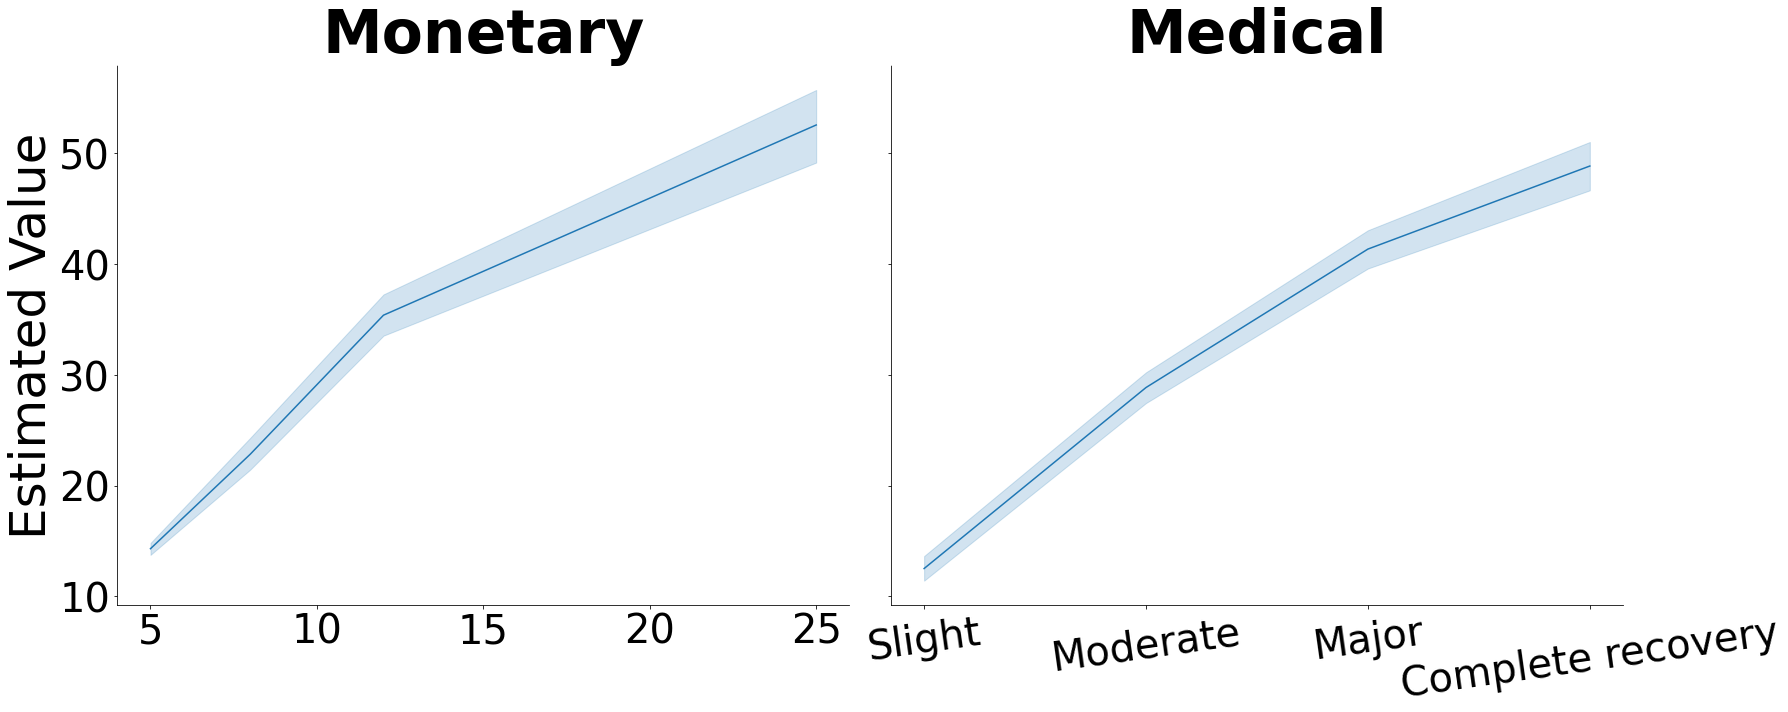

In [54]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=True) # Initialize a 1x2 subplot layout, with a shared y-axis.

# Plot the estimated value for each level in the 'Monetary' context on the first axis.
sns.lineplot(data=df_long_mon, x='levelName', y='value', ax=axes[0])

# Plot the estimated value for each level in the 'Medical' context on the second axis.
sns.lineplot(data=df_long_med, x='levelName', y='value', ax=axes[1])

# Set the title for each subplot.
axes[0].set_title('Monetary', fontweight="bold", size=60)
axes[1].set_title('Medical', fontweight="bold", size=60)

# Set the y-axis label for the first subplot.
axes[0].set_ylabel('Estimated Value', fontsize=50.0)

# Remove x-axis labels as they are self-explanatory with the data points.
axes[0].set_xlabel('', fontsize=50.0)
axes[1].set_xlabel('', fontsize=50.0)

# Adjust the tick parameters to increase font size, ensuring better readability.
axes[0].tick_params(axis='both', which='major', labelsize=40)
axes[1].tick_params(axis='both', which='major', labelsize=40)

# Add a slight rotation to the x-axis tick labels on the second plot for better visualization.
axes[1].tick_params(axis='x', labelrotation=8)

# Set the background color for both plots to white for clarity and aesthetic appeal.
axes[0].set_facecolor('White')
axes[1].set_facecolor('White')

# Remove the right and top spines from both plots to reduce visual clutter.
for spine in ['right', 'top']:
    axes[0].spines[spine].set_color('white')
    axes[1].spines[spine].set_color('white')

# Adjust the layout to ensure that the plots do not overlap and everything fits well.
fig.tight_layout()

In [55]:
def Utility_age(df, n_subs, idx):
    """
    Bayesian model to estimate the utility of choices given age as a covariate.
    
    Parameters:
    - df: DataFrame with data on choices, values, risks, ambiguity, and normalized age ('ageZ') for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Posterior samples of the model.
    """
    with pm.Model() as RiskAmb_beta:  # Define a PyMC3 probabilistic model context.
        
        # Hyper Priors
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower=1)  # Truncated hyperprior for the alpha parameter's rate.
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower=1)  # Truncated hyperprior for the alpha parameter's shape.
        
        gMu  = pm.HalfNormal('gMu', 1)  # Half normal hyperprior for the group mean of γ.
        gSig = pm.Gamma('gSig', 2, 1)   # Gamma hyperprior for the group SD of γ.
        
        bMu  = pm.Normal('bMu', .65, 1) # Normal hyperprior for group mean of β.
        bSig = pm.Gamma('bSig', 2, 1)   # Gamma hyperprior for group SD of β.

        # Subject-level Priors
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape=n_subs) # Beta prior for each subject's α.
        α = pm.Deterministic('α', alpha * 2)  # Deterministic transformation of alpha to double its values.
        β = pm.TruncatedNormal('β', bMu, bSig, lower=-1.5, upper=1.5, shape=n_subs)  # Truncated normal prior for each subject's β.
        γ = pm.Lognormal('γ', gMu, gSig, shape=n_subs) # Lognormal prior for each subject's γ.
        
        # Age-based priors to capture effect of age on risk and ambiguity.
        age_Risk = pm.Normal('age_Risk', 0, 1)  # Normal prior for the effect of age on risk.
        age_Amb  = pm.Normal('age_Amb', 0, 1)  # Normal prior for the effect of age on ambiguity.
        
        # Compute risk and ambiguity considering age effect.
        risk = α[idx] + age_Risk * df['ageZ'].values
        amb  = β[idx] + age_Amb * df['ageZ'].values
        
        # Calculate expected value of outcome given the updated risk and ambiguity.
        value = df['value'].values ** risk
        prob  = df['risk'].values - (amb * (df['ambiguity'].values/2))
        svLotto = value * prob
        svRef   = 5 ** risk

        # Transform the subjective value difference between lottery and reference into a choice probability.
        p  = (svLotto - svRef)/γ[idx]
        mu = pm.invlogit(p)  # Inverse logit transformation to get a probability.

        # Likelihood of observed choices given the model.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        # Generate samples from the posterior distribution.
        trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)
        
    return(trace)


In [56]:
# Estimate the age effect on risk and ambiguity using the utility function on monetary choices
mon_beta_age = Utility_age(db_mon, n_subs, sub_idx)

# Provide a summary of the posterior distribution for the age effects on Risk and Ambiguity 
# from the estimated Bayesian model for monetary choices.
az.summary(mon_beta_age, var_names=['age_Risk', 'age_Amb'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, gMu, gSig, bMu, bSig, alpha, β, γ, age_Risk, age_Amb]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1191 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age_Risk,-0.028,0.036,-0.096,0.040,0.001,0.001,1320.0,2447.0,1.0
age_Amb,-0.065,0.081,-0.207,0.096,0.002,0.002,1262.0,1721.0,1.0


In [57]:
def Utility_age_std(df, n_subs, idx):
    """
    Bayesian model to estimate the utility of choices given age as a covariate with age divided by 100.
    
    Parameters:
    - df: DataFrame with data on choices, values, risks, ambiguity, and  age for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Posterior samples of the model.
    """
    with pm.Model() as RiskAmb_beta:  # Define a PyMC3 probabilistic model context.
        
        # Hyper Priors
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower=1)  # Truncated hyperprior for the alpha parameter's rate.
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower=1)  # Truncated hyperprior for the alpha parameter's shape.
        
        gMu  = pm.HalfNormal('gMu', 1)  # Half normal hyperprior for the group mean of γ.
        gSig = pm.Gamma('gSig', 2, 1)   # Gamma hyperprior for the group SD of γ.
        
        bMu  = pm.Normal('bMu', .65, 1) # Normal hyperprior for group mean of β.
        bSig = pm.Gamma('bSig', 2, 1)   # Gamma hyperprior for group SD of β.

        # Subject-level Priors
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape=n_subs) # Beta prior for each subject's α.
        α = pm.Deterministic('α', alpha * 2)  # Deterministic transformation of alpha to double its values.
        β = pm.TruncatedNormal('β', bMu, bSig, lower=-1.5, upper=1.5, shape=n_subs)  # Truncated normal prior for each subject's β.
        γ = pm.Lognormal('γ', gMu, gSig, shape=n_subs) # Lognormal prior for each subject's γ.
        
        # Age-based priors to capture effect of age on risk and ambiguity.
        age_Risk = pm.Normal('age_Risk', 0, 1)  # Normal prior for the effect of age on risk.
        age_Amb  = pm.Normal('age_Amb', 0, 1)  # Normal prior for the effect of age on ambiguity.
        
        # Compute risk and ambiguity considering age effect.
        risk = α[idx] + age_Risk * df['age'].values/100
        amb  = β[idx] + age_Amb * df['age'].values/100
        
        # Calculate expected value of outcome given the updated risk and ambiguity.
        value = df['value'].values ** risk
        prob  = df['risk'].values - (amb * (df['ambiguity'].values/2))
        svLotto = value * prob
        svRef   = 5 ** risk

        # Transform the subjective value difference between lottery and reference into a choice probability.
        p  = (svLotto - svRef)/γ[idx]
        mu = pm.invlogit(p)  # Inverse logit transformation to get a probability.

        # Likelihood of observed choices given the model.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        # Generate samples from the posterior distribution.
        trace = pm.sample(tune=2000, draws=2000, return_inferencedata=True, target_accept=0.99)
        
    return(trace)


In [58]:
# Estimate the age effect on risk and ambiguity using the utility function on monetary choices
mon_beta_age_std = Utility_age_std(db_mon, n_subs, sub_idx)

# Provide a summary of the posterior distribution for the age effects on Risk and Ambiguity 
# from the estimated Bayesian model for monetary choices.
az.summary(mon_beta_age_std, var_names=['age_Risk', 'age_Amb'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, gMu, gSig, bMu, bSig, alpha, β, γ, age_Risk, age_Amb]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1579 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age_Risk,-0.012,0.141,-0.280,0.253,0.006,0.004,506.0,955.0,1.01
age_Amb,-0.317,0.270,-0.848,0.159,0.012,0.008,514.0,1117.0,1.01
